In [2]:
import pennylane as qml
import numpy as np
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import matplotlib.pyplot as plt




In [3]:
def destructive_swap(nq_state):
  n_qubit = nq_state*2
  device = 'default.qubit'
  dvc=qml.device(device, wires=n_qubit, shots=None)

  @qml.qnode(dvc,interface='jax', diff_method=None)
  def cirq(param):
    for i,wires in enumerate(dvc.wires):
      qml.RY(param[i],wires=wires)
    qml.Barrier(dvc.wires)
    for wires in range(nq_state): 
      qml.CNOT(wires=[wires,wires+nq_state])
      qml.Hadamard(wires)

    return qml.probs(dvc.wires)
  return cirq   

def interpret_results(data):
  def generate_combinations(n):
      # Generate all combinations of '0' and '1' of length n
      combinations = [''.join(comb) for comb in itertools.product('01', repeat=n)]
      return combinations

  def check_parity_bitwise_and(s):
    n = len(s)
    first_half = s[:n//2]
    second_half = s[n//2:]
    and_result = ''.join('1' if first_half[i] == '1' and second_half[i] == '1' else '0' for i in range(n//2))
    parity = and_result.count('1') % 2

    return parity

  dictdata = dict(zip(generate_combinations(len(data)),data))
  kk={}
  for k,item in dictdata.items():
    if dictdata[k]>0.00000001:
      kk[k]=item
  fail =0
  for k,i in kk.items():
    if check_parity_bitwise_and(k):
      fail += i
  return fail



# Old autoencoder

In [43]:
def autoencodert(n_qubit,repetition=2):
  device = 'default.qubit'
  dvc=qml.device(device, wires=n_qubit, shots=None)
  def dense(a,b,parameters):
      qml.RY(parameters[0],wires=a)
      qml.RY(parameters[1],wires=b)
      qml.CNOT(wires=[a,b])
      qml.RY(parameters[2],wires=a)
      qml.RY(parameters[3],wires=b)
      qml.CNOT(wires=[b,a])

  def pool(a,b,parameters):
      qml.CRZ(parameters[0],wires=[a,b])
      qml.X(a)  
      qml.CRX(parameters[1],wires=[a,b])

  @qml.qnode(dvc,interface='jax', diff_method=None)
  def cirq(param):
    start=0
    for i in range(repetition):
      if start % 2!=0:
        raise Exception('The number of qubits should be a power of 2 greater than 2 to the power of repetition')

      for a in range(start,( n_qubit-start)//2+start):
          param_corrente=sum([6*n_qubit//2**(i+1) for i in range(i)])+a*6
          dense(a,a+(n_qubit-start)//2,param[param_corrente:param_corrente+4])
          pool(a,a+(n_qubit-start)//2,param[param_corrente+4:param_corrente+6])
      start+=n_qubit//(2**(i+1))
      qml.Barrier(dvc.wires)

    return qml
  return cirq,n_qubit-n_qubit//(2**(repetition))

repetition=4
num_params=sum([6*n_qubit//2**(i+1) for i in range(repetition)])
cirq,trash=autoencodert(4)
fig, ax = qml.draw_mpl(cirq)([1]*num_params)
plt.show()



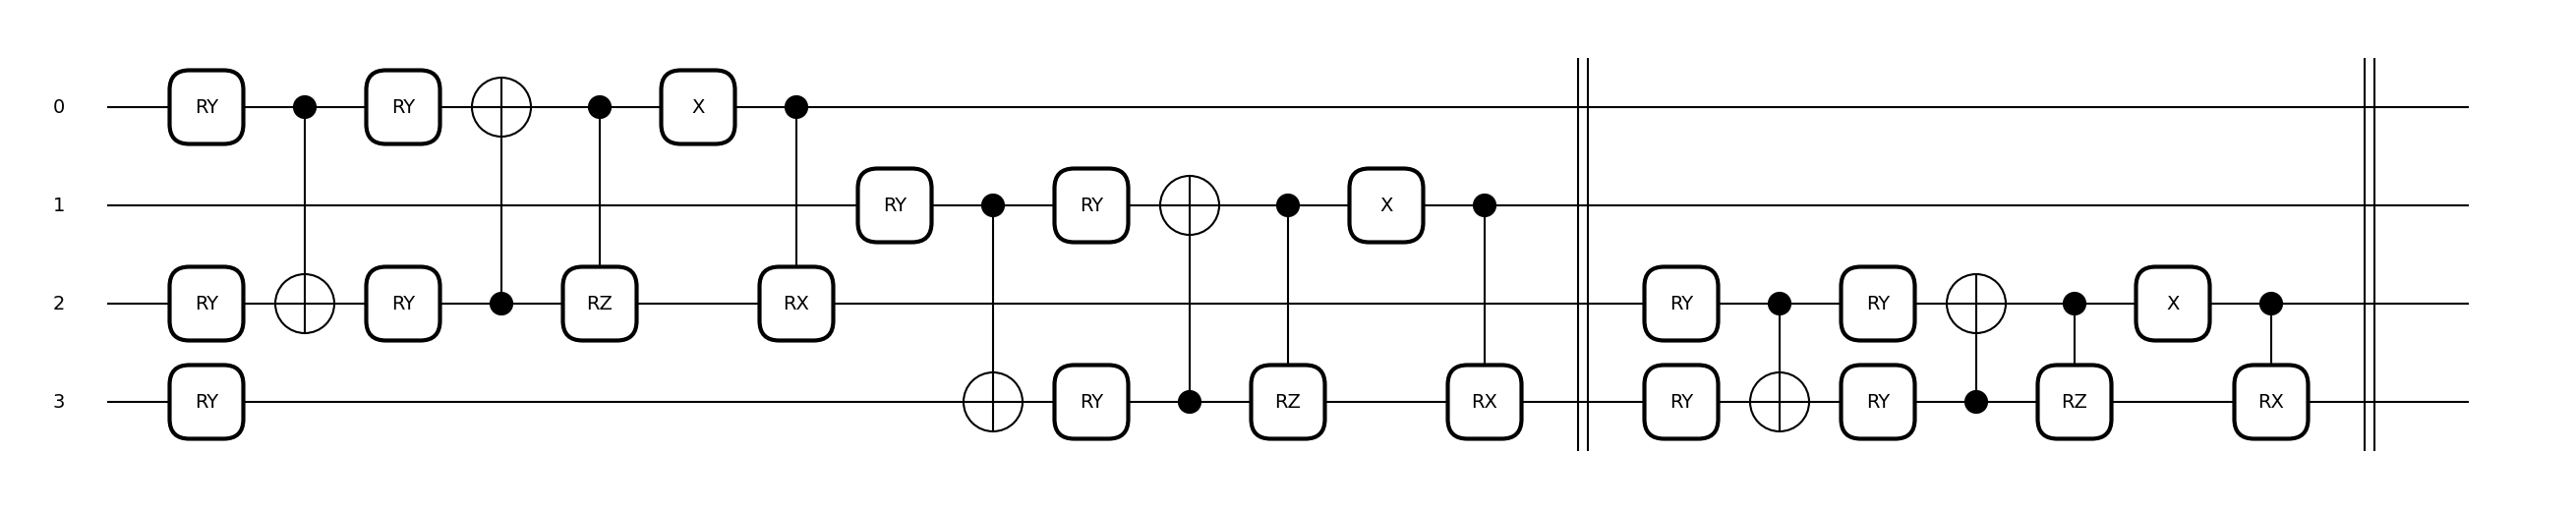

# Train autoencoder


In [176]:
n_qubit_autoencoder=8
repetition=3
n_qubit_swap=n_qubit_autoencoder-n_qubit_autoencoder//(2**(repetition))
n_qubit=n_qubit_autoencoder+n_qubit_swap
num_params=sum([6*n_qubit_autoencoder//2**(i+1) for i in range(repetition)])


In [177]:
def dense(a,b,parameters):
    qml.RY(parameters[0],wires=a)
    qml.RY(parameters[1],wires=b)
    qml.CNOT(wires=[a,b])
    qml.RY(parameters[2],wires=a)
    qml.RY(parameters[3],wires=b)
    qml.CNOT(wires=[b,a])

def pool(a,b,parameters):
    qml.CRZ(parameters[0],wires=[a,b])
    qml.X(a)  
    qml.CRX(parameters[1],wires=[a,b])

def cirq(offset,param):
    start=0
    for i in range(repetition):
        if start % 2!=0:
            raise Exception('The number of qubits should be a power of 2 greater than 2 to the power of repetition')

        for a in range(start,( n_qubit_autoencoder-start)//2+start):
            param_corrente=sum([6*n_qubit_autoencoder//2**(j+1) for j in range(i)])+(a-start)*6
            a+=offset
            dense(a,a+(n_qubit_autoencoder-start)//2,param[param_corrente:param_corrente +4])
            pool(a,a+(n_qubit_autoencoder-start)//2,param[param_corrente+4:param_corrente+6])
        start+=n_qubit_autoencoder//(2**(i+1))

        

In [178]:
def destructive_swap():
    for wires in range(n_qubit_swap): 
        qml.CNOT(wires=[wires,wires+n_qubit_swap])
        qml.Hadamard(wires)

    return qml


In [182]:

device = 'default.qubit'
dvc=qml.device(device, wires=n_qubit, shots=None)

@qml.qnode(dvc,interface='jax', diff_method=None)
def useit(param):
    cirq(n_qubit_swap,param)
    qml.Barrier(dvc.wires)
    destructive_swap()
    return qml.probs(list(range(n_qubit_swap*2)))

    


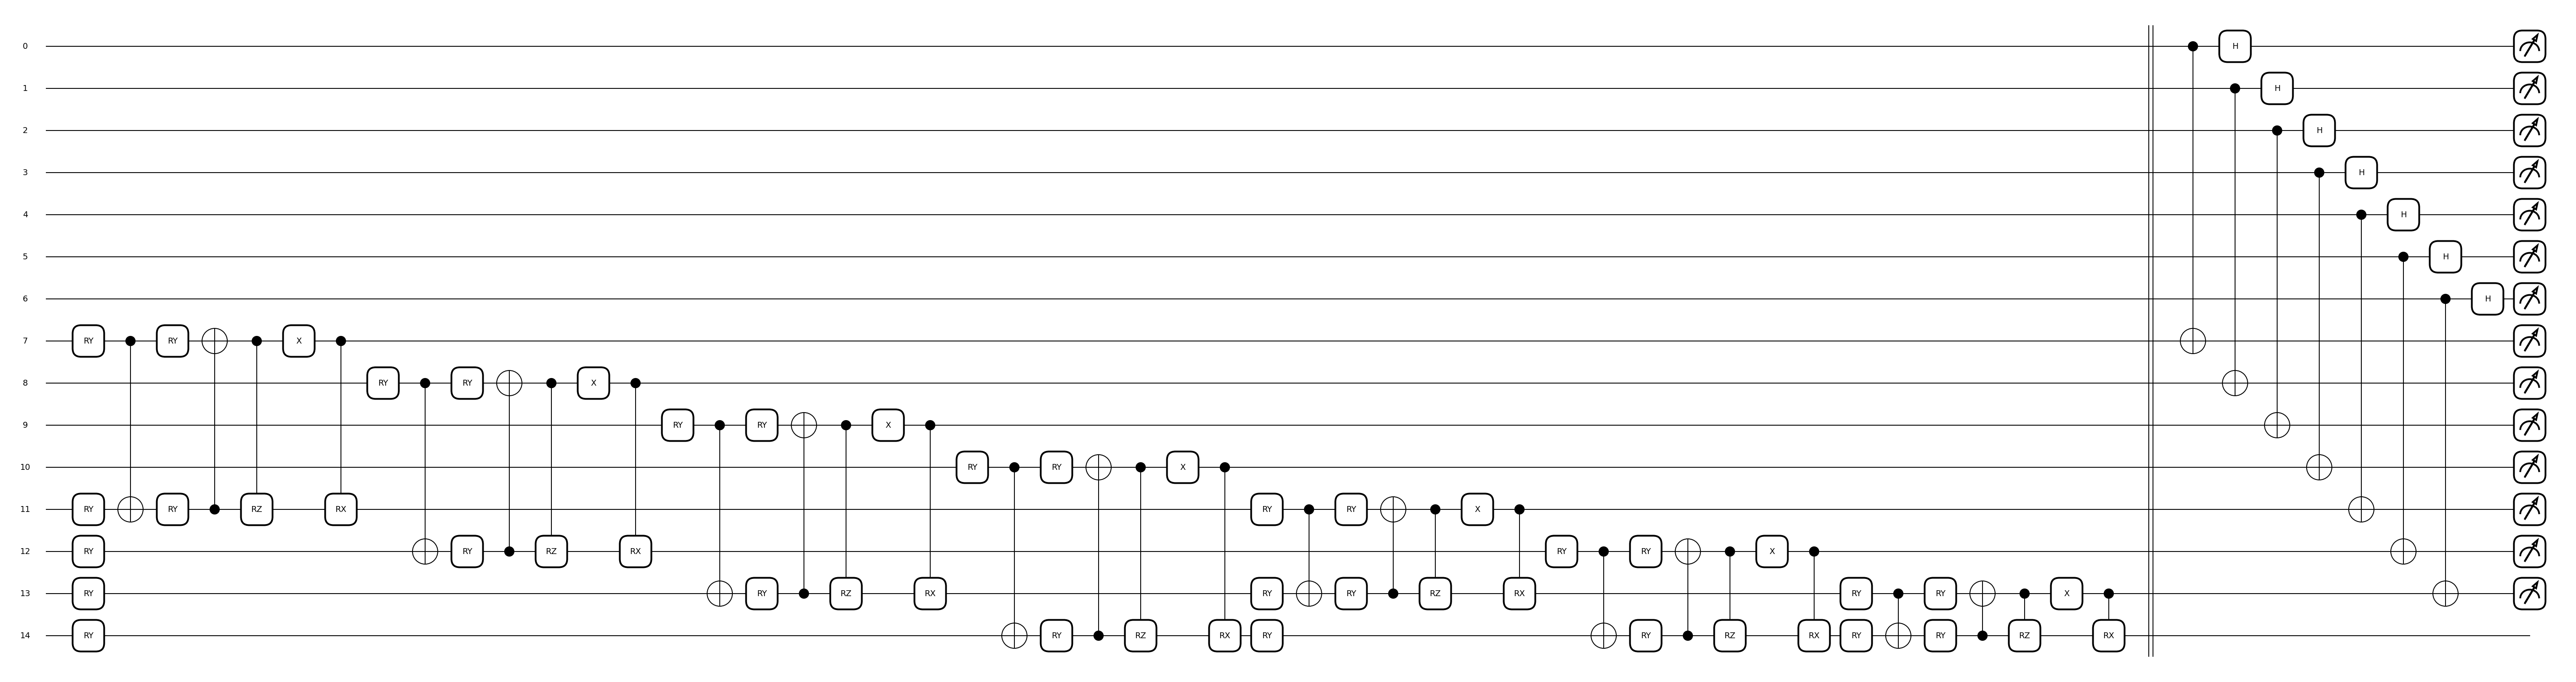

In [183]:
fig, ax = qml.draw_mpl(useit)([1]*num_params)
